# 7. Reinforcement learning for Control 🐶

<a href="https://githubtocolab.com/edgarsmdn/MLCE_book/blob/main/07_RL_Control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

```{attention} 
In this tutorial we are going to use the same CSTR example as in [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html). Therefore, it is a great idea to first look at tutorial 6 to have the complete context.
```



## Goals of this exercise 🌟
- Perform reactor control using reinforcement learning
- Revise the concept of transfer learning
- Revise the concept of policy gradients


## A quick reminder ✅

Reinforcement Learning (RL) is an area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward. 

RL algorithms are particularly well suited to address sequential decision making problems under uncertainty, for example, they are generally applied to solve problems in a Markov decision process (MDP) setting. A control problem (just like reactor control) is a sequential decision making problem under uncertainty, where at every time-step the controller (agent in the RL context) must take an optimal (control) action, and it is hindered by process disturbances (uncertainty). There are many types of reinforcement leanring algorithms, in this notebook tutorial we will focus on **policy optimization** algorithms. 

We can define an RL agent as a controller that given a state ${\bf x}$ outputs the optimal action ${\bf u}$

$${\bf u}:=\pi({\bf x})$$

If the controller $\pi(\cdot)$ is parametrized, say by neural network weights $\boldsymbol{\theta}$, we can write 

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

where ${\bf \theta}$ are parameters determined *a priori*. We could define the PID controller in this same fashion:

$$u:=\text{PID}(x;K_P,K_I,K_D)$$

In many cases, to fullfil the exploration - exploitation dilemma or in games, stochastic policies are used, which instead of outputting a single action ${\bf u}$, output a distributions over actions $p({\bf x};\boldsymbol{\theta})$. 

$${\bf u} \sim p({\bf x};\boldsymbol{\theta})$$

In practice, it is common to have a neural network output the moments (mean and variance), and to then draw an action from the distribution parametrized by this mean and variance

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := p({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$

You can find a Taxonomy of RL Algorithms below.

```{figure} media/07_RL/algorithms.PNG
:alt: kNN
:width: 100%
:align: center

A broad classification of reinforcement learning algorithms. [source](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html)
```

In [24]:
import torch
import torch.nn.functional as Ffunctional
import copy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import StrMethodFormatter
from pylab import grid
import time
import random

The code below corresponds to the CSTR model and parameters of tutorial 6.

In [25]:
#@title CSTR code from tutorial 6

eps  = np.finfo(float).eps

###############
#  CSTR model #
###############

# Taken from http://apmonitor.com/do/index.php/Main/NonlinearControl

def cstr(x,t,u):

    # ==  Inputs == #
    Tc  = u   # Temperature of cooling jacket (K)

    # == States == #
    Ca = x[0] # Concentration of A in CSTR (mol/m^3)
    T  = x[1] # Temperature in CSTR (K)

    # == Process parameters == #
    Tf     = 350    # Feed temperature (K)
    q      = 100    # Volumetric Flowrate (m^3/sec)
    Caf    = 1      # Feed Concentration (mol/m^3)
    V      = 100    # Volume of CSTR (m^3)
    rho    = 1000   # Density of A-B Mixture (kg/m^3)
    Cp     = 0.239  # Heat capacity of A-B Mixture (J/kg-K)
    mdelH  = 5e4    # Heat of reaction for A->B (J/mol)
    EoverR = 8750   # E -Activation energy (J/mol), R -Constant = 8.31451 J/mol-K
    k0     = 7.2e10 # Pre-exponential factor (1/sec)
    UA     = 5e4    # U -Heat Transfer Coefficient (W/m^2-K) A -Area - (m^2)
    
    # == Equations == #
    rA     = k0*np.exp(-EoverR/T)*Ca # reaction rate
    dCadt  = q/V*(Caf - Ca) - rA     # Calculate concentration derivative
    dTdt   = q/V*(Tf - T) \
              + mdelH/(rho*Cp)*rA \
              + UA/V/rho/Cp*(Tc-T)   # Calculate temperature derivative

    # == Return xdot == #
    xdot    = np.zeros(2)
    xdot[0] = dCadt
    xdot[1] = dTdt
    return xdot

data_res = {} 
# Initial conditions for the states
x0             = np.zeros(2)
x0[0]          = 0.87725294608097
x0[1]          = 324.475443431599
data_res['x0'] = x0

# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# Store results for plotting
Ca = np.zeros(len(t));      Ca[0]  = x0[0]
T  = np.zeros(len(t));      T[0]   = x0[1]    
Tc = np.zeros(len(t)-1);   

data_res['Ca_dat'] = copy.deepcopy(Ca)
data_res['T_dat']  = copy.deepcopy(T) 
data_res['Tc_dat'] = copy.deepcopy(Tc)

# noise level
noise             = 0.1
data_res['noise'] = noise

# control upper and lower bounds
data_res['Tc_ub']  = 305
data_res['Tc_lb']  = 295
Tc_ub              = data_res['Tc_ub']
Tc_lb              = data_res['Tc_lb']

# desired setpoints
n_1                = int(n/2)
n_2                = n - n_1
Ca_des             = [0.8 for i in range(n_1)] + [0.9 for i in range(n_2)]
T_des              = [330 for i in range(n_1)] + [320 for i in range(n_2)]
data_res['Ca_des'] = Ca_des
data_res['T_des']  = T_des

##################
# PID controller #
##################

def PID(Ks, x, x_setpoint, e_history):

    Ks    = np.array(Ks)
    Ks    = Ks.reshape(7, order='C')

    # K gains
    KpCa = Ks[0]; KiCa = Ks[1]; KdCa = Ks[2]
    KpT  = Ks[3]; KiT  = Ks[4]; KdT  = Ks[5]; 
    Kb   = Ks[6]
    # setpoint error
    e = x_setpoint - x
    # control action
    u  = KpCa*e[0] + KiCa*sum(e_history[:,0]) + KdCa*(e[0]-e_history[-1,0])
    u += KpT *e[1] + KiT *sum(e_history[:,1]) + KdT *(e[1]-e_history[-1,1])
    u += Kb
    u  = min(max(u,data_res['Tc_lb']),data_res['Tc_ub'])

    return u

In [26]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(Ca_dat, T_dat, Tc_dat, data_simulation):    
    
    Ca_des = data_simulation['Ca_des']
    T_des = data_simulation['T_des']
    
    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    plt.plot(t, np.median(Ca_dat,axis=1), 'r-', lw=3)
    plt.gca().fill_between(t, np.min(Ca_dat,axis=1), np.max(Ca_dat,axis=1), 
                           color='r', alpha=0.2)
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,2)
    plt.plot(t, np.median(T_dat,axis=1), 'c-', lw=3)
    plt.gca().fill_between(t, np.min(T_dat,axis=1), np.max(T_dat,axis=1), 
                           color='c', alpha=0.2)
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.subplot(3,1,3)
    plt.step(t[1:], np.median(Tc_dat,axis=1), 'b--', lw=3)
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))

    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t'] 
    Ca_train = np.array(data_simulation['Ca_train'])
    T_train = np.array(data_simulation['T_train'])
    Tc_train = np.array(data_simulation['Tc_train'])
    Ca_des   = data_simulation['Ca_des']
    T_des    = data_simulation['T_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    for run_i in range(repetitions):
        plt.plot(t, Ca_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
    plt.step(t, Ca_des, '--', lw=1.5, color='black')
    plt.ylabel('Ca (mol/m^3)')
    plt.xlabel('Time (min)')
    plt.legend(['Concentration of A in CSTR'],loc='best')
    plt.title('Training plots')
    plt.ylim([.75, .95])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,2)
    for run_i in range(repetitions):
        plt.plot(t, T_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
    plt.step(t, T_des, '--', lw=1.5, color='black')
    plt.ylabel('T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Reactor Temperature'],loc='best')
    plt.ylim([335, 317])
    plt.xlim(min(t), max(t))
    grid(True)

    plt.subplot(3,1,3)
    for run_i in range(repetitions):
        plt.step(t[1:], Tc_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
    plt.ylabel('Cooling T (K)')
    plt.xlabel('Time (min)')
    plt.legend(['Jacket Temperature'],loc='best')
    plt.xlim(min(t), max(t))
    grid(True)
    
    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None: 
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point 
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

## Stochastic Policy Search 🎲

### Policy network

In the same way as we used data-driven optimization to tune the gains $K_P,K_I,K_D$ in the PID controllers (cf. [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html)), we can use the same approach to tune (or train) the parameters (or weights) $\boldsymbol{\theta}$ of a neural network. 

There is research that suggest that evolutionary (or stochastic search in general) algorithms can be as good (or better in some contexts) than traditional techniques, for more details see [Evolution Strategies as a Scalable Alternative to Reinforcement Learning](https://openai.com/research/evolution-strategies), the paper can be found [here](https://arxiv.org/abs/1703.03864).

The difference here, with respect to the controller tuning that we perform on [tutorial notebook 6](https://edgarsmdn.github.io/MLCE_book/06_PID_tuning.html) is that the neural networks have many parameters and the number of iterations needed are relatively high, and therefore, model/surrogate-based data-driven optimization methods do not scale as well and might not be the best choice. Therefore, stochastic search optimization methods (e.g. genetic algorithms, particle swarm optimization) can be a good alternative. You can check some pedagogical implementations [here](https://edgarsmdn.github.io/projects/stochastic_optimization_algorithms/).

In the following section we build a relatively simple neural network controller in PyTorch

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and hard code a simple stochastic search algorithm (it is a combination of random search and local random search) to manipulate the weights $\boldsymbol{\theta}$, evaluate the performance of the current weight values, and iterate.

**Neural Network Controller Training Algorithm**

*Initialization*

Collect $d$ initial datapoints $\mathcal{D}=\{(\hat{f}^{(j)}=\sum_{k=0}^{k=T_f} (e(k))^2,~ \boldsymbol{\theta}^{(j)}) \}_{j=0}^{j=d}$ by simulating $x(k+1) = f(x(\cdot),u(\cdot))$ for different values of $\boldsymbol{\theta}^{(j)}$, set a small radious of search $r$

*Main loop*

1. *Repeat*
2. $~~~~~~$ Choose best current known parameter value $\boldsymbol{\theta}^*$.
3. $~~~~~~$ Sample $n_s$ values around $\boldsymbol{\theta}^*$, that are at most some distance $r$, $\bar{\boldsymbol{\theta}}^{(0)},...,\bar{\boldsymbol{\theta}}^{(n_s)}$
3. $~~~~~~$ Simulate new values  $ x(k+1) = f(x(k),u(\bar{\boldsymbol{\theta}}^{(i)};x(k))), ~ k=0,...,T_f-1, i=0,...,n_s $
4. $~~~~~~$ Compute $\hat{f}^{(i)}=\sum_{k=0}^{k=T_f} (e(k))^2, i=0,...,n_s$.
5. $~~~~~~$ **if** $\bar{\boldsymbol{\theta}}^{\text{best}}$ is better than $\boldsymbol{\theta}^*$, then $ \boldsymbol{\theta}^* \leftarrow \bar{\boldsymbol{\theta}}^{\text{best}}$, **else** $ r \leftarrow r\gamma$, where $ 0 < \gamma <1 $ 
6. until stopping criterion is met.

Remarks: 
* The initial collection of $d$ points is generally done by some space filling (e.g. [Latin Hypercube](https://en.wikipedia.org/wiki/Latin_hypercube_sampling), [Sobol Sequence](https://en.wikipedia.org/wiki/Sobol_sequence)) procedure.

First, let's create a neural network in PyTorch that has two hidden layers, one being double the size of the input layer and the other double the size of the output layer. We will use the activation functions [LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) and [ReLU6](https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html). If you want a more gentle introduction to neural nets in Pytorch, check the [tutorial notebook 4](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html).

In [27]:
##################
# Policy Network #
##################

class Net(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
    def __init__(self, **kwargs):
        super(Net, self).__init__()

        self.dtype    = torch.float

        # Unpack the dictionary 
        self.args     = kwargs

        # Get info of machine
        self.use_cuda = torch.cuda.is_available() 
        self.device   = torch.device("cpu")

        # Define ANN topology 
        self.input_size = self.args['input_size']
        self.output_sz  = self.args['output_size']
        self.hs1        = self.input_size*2
        self.hs2        = self.output_sz*2 

        # Define layers 
        self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
        self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
        self.output  = torch.nn.Linear(self.hs2, self.output_sz)

    def forward(self, x):
        #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
        x = x.view(1, 1, -1).float()
        y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
        y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
        y = Ffunctional.relu6(self.output(y))   # range (0,6)

        return y

We normalize the inputs and states

In [28]:
# normalization for states and actions 
data_res['x_norm'] = np.array([[.8, 315,0, 0],[.1, 10,.1, 20]]) # [mean],[range]
data_res['u_norm'] = np.array([[10/6],[295]])    # [range/6],[bias]

Now, let's create the objective function for the policy network. 

```{tip} Notice the difference between this objective function and the objective function use in [tutorial 6](https://edgarsmdn.github.io/MLCE_book/04_DNN_VLE.html). We have included a conditional to switch between algorithms.
```


In [29]:
def J_PolicyCSTR(policy, data_res=data_res, policy_alg='PID', 
                 collect_training_data=True, traj=False, episode=False):
    
    # load data
    Ca    = copy.deepcopy(data_res['Ca_dat'])
    T     = copy.deepcopy(data_res['T_dat'])
    Tc    = copy.deepcopy(data_res['Tc_dat'])
    t     = copy.deepcopy(data_res['t']) 
    x0    = copy.deepcopy(data_res['x0'])    
    noise = data_res['noise']
    
    # setpoints      
    Ca_des = data_res['Ca_des']; T_des = data_res['T_des']
    
    # upper and lower bounds
    Tc_ub  = data_res['Tc_ub'];  Tc_lb  = data_res['Tc_lb']
    
    # normalized states and actions
    x_norm = data_res['x_norm']; u_norm = data_res['u_norm'];

    # initiate
    x         = x0
    e_history = []

    # log probs
    if policy_alg == 'PG_RL':
      log_probs = [None for i in range(len(t)-1)]
    
    # Simulate CSTR
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([Ca_des[i],T_des[i]])

        #### PID ####
        if policy_alg == 'PID':
          if i == 0:
            Tc[i] = PID(policy, x, x_sp, np.array([[0,0]]))
          else:
            Tc[i] = PID(policy, x, x_sp, np.array(e_history))

        # --------------> New compared to tutorial 6 <-------------------
        #### Stochastic Policy Search ####
        elif policy_alg == 'SPS_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = torch.tensor(xknorm)
          # compute u_k from policy
          mean_uk      = policy(xknorm_torch).detach().numpy()
          u_k          = np.reshape(mean_uk, (1, 1))
          # print("The first value for u_k is:", u_k)
          u_k          = u_k*u_norm[0] + u_norm[1]
          u_k          = u_k[0]
          # print("The second value for u_k is:", u_k)
          u_k          = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]        = u_k[0]
          # print("The third value for u_k is:", Tc[i])

        #### Policy Gradients #### 
        # See next section for the explanation on Policy gradients!
        elif policy_alg == 'PG_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = Tensor(xknorm)
          # compute u_k distribution
          m, s                      = policy(xknorm_torch)[0,0]
          s                         = s + eps
          mean_uk, std_uk           = mean_std(m, s)
          u_k, logprob_k, entropy_k = select_action(mean_uk, std_uk)
          u_k                       = np.reshape(u_k.numpy(), (nu))
          # hard bounds on inputs
          u_k                       = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]                     = u_k
          log_probs[i] = logprob_k
        # ----------------------------------------------------------------

        # simulate system
        y            = odeint(cstr,x,ts,args=(Tc[i],))
        # add process disturbance
        s            = np.random.uniform(low=-1, high=1, size=2)
        Ca[i+1]      = y[-1][0] + noise*s[0]*0.1    
        T[i+1]       = y[-1][1] + noise*s[1]*5     
        # state update
        x[0]         = Ca[i+1]
        x[1]         = T[i+1]
        # compute tracking error
        e_history.append((x_sp-x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/0.2+np.abs(np.array(e_history)[:,1])/15
    # penalize magnitud of control action
    u_mag = np.abs(Tc[:]-Tc_lb)/10
    u_mag = u_mag/10
    # penalize change in control action
    u_cha = np.abs(Tc[1:]-Tc[0:-1])/10
    u_cha = u_cha/10

    # collect data for plots
    if collect_training_data:
        data_res['Ca_train'].append(Ca)
        data_res['T_train'].append(T)
        data_res['Tc_train'].append(Tc)
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)

    # sums
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if episode:
      # See next section for the explanation on Policy gradients!
      sum_logprob = sum(log_probs)
      reward      = -(error + u_mag + u_cha)
      return reward, sum_logprob
    
    if traj:
      return Ca, T, Tc
    else:
      return error + u_mag + u_cha


As mentioned above, we are going to use a stochastic search algorithm that combines random search with local random search to optimize the policy network.

The code below has two main elements:

**Random Search Step**: During this step neural network weights are sampled uniformely (given some bounds). Each set of parameters is evaluated (a simulation is run), and the parameter set that performed best is passed to the next step.

An illustration of how Random Search would look in a 2-dimensional space is shown below

```{figure} media/07_RL/random_search.PNG
:alt: kNN
:width: 75%
:align: center

An illustration of the random search algorithm. [source](https://commons.wikimedia.org/wiki/File:Hyperparameter_Optimization_using_Random_Search.svg)
```

**Local Search Step**: This step starts from the best parameter values found by the *Random Search Step*. Subsequently it does a random search close by the best value found (hence termed stocastic local search). Additionally, if after some number of interations a better function value has not been found (also via simulating the system), the radius of search is reduced. 

An illustration of how Local search would look in a 2-dimensional space is shown below

```{figure} media/07_RL/local_random_search.PNG
:alt: kNN
:width: 70%
:align: center

An illustration of the local search algorithm.
```

By combining a 'global search' strategy (Random search) and a 'local search' strategy (Local search) we balance exploration and exploitation which is a key concept in reinforcement learning.

In [123]:
#######################
# auxiliary functions #
#######################

def sample_uniform_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min \
              for k, v in params_prev.items()}              
    return params

def sample_local_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min + v \
              for k, v in params_prev.items()}              
    return params

def extract_NN_values(list_of_params):
    rows_tensors = []
    for params_dict in list_of_params:
        layer_shapes = []
        list_tensors = []
        layer_sizes = []
        for tensor in params_dict.values():
            list_tensors.append(torch.flatten(tensor))
            layer_sizes.append(torch.numel(tensor))
            layer_shapes.append(tensor.size())
        row_tensors = torch.cat(list_tensors)
        rows_tensors.append(row_tensors)
    mat_tensors = torch.stack(rows_tensors)
    return mat_tensors, layer_sizes, layer_shapes
    
def convert_to_NN_dict(tensor, layer_sizes, layer_shapes, params):
    split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
    NN_values = torch.tensor_split(tensor.squeeze(), split_indices, dim=0)
    NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    dict_names = list(params.keys())
    dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
    return dict_params
    


###################
# Genetic Algorithm
###################
    
def GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.1, iterations=12, sample_size=10):
    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise population
    population = []
    
    # initialise inputs
    for i in range(sample_size):
        member = sample_uniform_params(params, lower_bound, upper_bound)
        population.append(copy.deepcopy(member))
    
    #print("Population before:", population)
        
    for i in range(iterations+1):
        print("Iteration", i)
        fun_population = [] # initialise empty list of rewards
        for j in range(len(population)):
            current_params = population[j] # fetch current NN parameter set
            policy_net.load_state_dict(current_params) # load set into NN
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') # evaluate NN in the controller simulation
            fun_population.append(reward) # add reward to the corresponding list
            
        fitness_scores = [1/value for value in fun_population] # evaluate the fitness score for each set of params
        total_fitness = sum(fitness_scores) # calculate total fitness score
        best_guess = population[fitness_scores.index(max(fitness_scores))] # determine best current set of params
        new_generation = [list(best_guess.values())] # it automatically becomes part of the new generation
        pop_aslist = [list(person.values()) for person in population] # turn the list of dict's into a list of lists, to be able to inde through them
        while len(new_generation) < sample_size:
            selection_probs = [score / total_fitness for score in fitness_scores] # define selection probabilities
            (parent1, parent2) = random.choices(pop_aslist, selection_probs, k=2) # select two parents
            children = []
            child1 = []
            child2 = []
            index = random.randint(1, len(population[0]))
            child1.extend(parent1[0:index])
            child1.extend(parent2[index:])
            child2.extend(parent2[0:index])
            child2.extend(parent1[index:])
            children.append(child1) # do crossover of parent guesses to form children
            children.append(child2)
            
            # Mutation stage
            for child in children:
                for n in range(len(child)):
                    if random.random() < mutation_rate:
                        child[n] = torch.rand(child[n].shape)*(upper_bound - lower_bound) + lower_bound
            new_generation.extend(children) # update new generation
        population = [] # reset current population
        for values in new_generation:
            count = 0
            dictentry = {}
            for layer in values:
                names = ('hidden1.weight', 'hidden1.bias', 'hidden2.weight', 'hidden2.bias', 'output.weight', 'output.bias')
                dictentry[names[count]] = layer
                count += 1
            population.append(dictentry)
        #print("Population after:", population)
    
    best_reward = fun_population[population.index(best_guess)]                            
    print("Best policy:", best_guess)
    print("Best reward:", best_reward)
    
    return best_guess, best_reward

##########################
# Particle swarm algorithm
##########################

def ParticleSwarm(lower_bound, upper_bound, no_particles, inertia, cognitive, social, tmax):
    
    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise empty particle and velocity lists
    dict_particles = [] 
    dict_velocities = []
    
    # populate the lists with particles/velocities, where each member is a set of params to be fed into NN
    for p in range(no_particles):
        particle = sample_uniform_params(params, lower_bound, upper_bound)
        p_velocity = sample_uniform_params(params, lower_bound/100, upper_bound/100)
        dict_particles.append(particle)
        dict_velocities.append(p_velocity)
    #print("Initial tensors:", dict_particles[0]) 
    # extract the neural network parameters only, turn them into a 2-d matrix: rows = particles, columns = NN weights
    
    particles, layer_sizes, layer_shapes = extract_NN_values(dict_particles)
    velocities, _, __ = extract_NN_values(dict_velocities)
    #print(particles)
    #print(layer_sizes)
    #print(particles)
    
    pbest = copy.deepcopy(particles)
    r_pbest = []
    for p in dict_particles:
        policy_net.load_state_dict(p)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        r_pbest.append(reward)
    r_pbest = np.array(r_pbest)
    gbest = pbest[r_pbest.argmin(), :]
    r_gbest = r_pbest.min()
    for t in range(tmax+1):
        print("Iteration", t)
        # Calculate new velocity value, use it to update particle value
        r1 = random.random()
        r2 = random.random()
        velocities = inertia*copy.deepcopy(velocities) + r1*cognitive*(pbest - particles) + r2*social*(gbest.reshape(1,-1) - particles) 
        particles = copy.deepcopy(particles) + velocities
        r_values = []
        NN_sets = torch.tensor_split(particles, no_particles, dim=0)
        #print("NN sets:", NN_sets)
        split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
        #print("Split indices:", split_indices)
        for nn_set in NN_sets:
            dict_params = convert_to_NN_dict(nn_set, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            r_values.append(reward)
        r_values = np.array(r_values)
        pbest[(r_values <= r_pbest), :] = particles[(r_values <= r_pbest), :]
        r_pbest[(r_values <= r_pbest)] = r_values[(r_values <= r_pbest)]
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
    
    
    best_policy = convert_to_NN_dict(gbest, layer_sizes, layer_shapes, params)
    print("Best policy:", best_policy)
    print("Best reward:", r_gbest)
    
    return best_policy, r_gbest
    
    
#######################
# Artificial Bee Colony
#######################
def ArtificialBeeColony(lower_bound, upper_bound, no_employed, no_onlooker, distance_value, iterations, scout_limit):
    
    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    dict_bees = [sample_uniform_params(params, lower_bound, upper_bound) for bee in range(no_employed)]
    bee_values, layer_sizes, layer_shapes = extract_NN_values(dict_bees)
    employed_bees = [{'solution': bee_values[i], 'fitness': None, 'trials': 0, 'reward': None} for i in range(len(bee_values))]
    best_reward = 1e8
    
    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for bee in employed_bees:
            second_bee = np.random.randint(0, no_employed)
            distance = np.random.uniform(-distance_value, distance_value)
            new_solution = bee['solution'] + distance*(bee['solution'] - employed_bees[second_bee]['solution'])
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if bee['reward'] == None or reward < bee['reward']:
                bee['solution'] = new_solution
                bee['reward'] = reward
                bee['fitness'] = fitness
                bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        total_fitness = np.sum([bee['fitness'] for bee in employed_bees])
        selection_probs = []
        for bee in employed_bees:
            selection_probs.append(bee['fitness'] / total_fitness)
            
        for onlooker in range(no_onlooker):
            onlooker_bee_list = random.choices(employed_bees, selection_probs, k=1)
            onlooker_bee = onlooker_bee_list[0]
            second_bee_index = np.random.randint(0, no_employed)
            second_bee = employed_bees[second_bee_index]
            distance = np.random.uniform(-distance_value, distance_value)
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if reward < onlooker_bee['reward']:
                onlooker_bee['solution'] = new_solution
                onlooker_bee['reward'] = reward
                onlooker_bee['fitness'] = fitness
                onlooker_bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        for bee in employed_bees:
            if bee['trials'] >= scout_limit and bee['reward'] != best_reward:
                rand_soln = sample_uniform_params(params, lower_bound, upper_bound)
                new_soln, layer_sizes, layer_shapes = extract_NN_values([rand_soln])
                bee['solution'] = new_soln[0]
                dict_params = convert_to_NN_dict(bee['solution'], layer_sizes, layer_shapes, params)
                policy_net.load_state_dict(dict_params)
                bee['reward'] = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                bee['fitness'] = 1/bee['reward']
                bee['trials'] = 0
            
        best_bee = min(employed_bees, key=lambda bee: bee['reward'])
        best_policy = convert_to_NN_dict(best_bee['solution'], layer_sizes, layer_shapes, params)
        best_reward = best_bee['reward']
        
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    
    return best_policy, best_reward

#####################
# Simulated Annealing
#####################

def SimulatedAnnealing(lower_bound, upper_bound, initial_accept_prob, max_iterations, step_size, temp_regime):
    
    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    probabilities = []
    temperatures = []
    function_counter = 1
    
    startpoint = sample_uniform_params(params, lower_bound, upper_bound)
    policy_net.load_state_dict(startpoint)
    reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    best_policy = startpoint
    best_reward = reward
    
    policy_tensor, layer_sizes, layer_shapes = extract_NN_values([startpoint])
    policy_tensor = policy_tensor[0]
    new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*2*step_size)
    dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
    policy_net.load_state_dict(dict_params)
    new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    functiondiff = new_reward - best_reward
    deltafunction = np.abs(functiondiff.copy())
    function_counter += 1
    
    # Use deltafunction to calculate an initial temperature
    max_temp = -deltafunction/(np.log(initial_accept_prob))
    temperature = max_temp.copy()
    
     # Condition if the new guess is better
    if functiondiff < 0:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward.copy()
        
    # Condition if the new guess is worse
    randomguess = random.random()
    if randomguess < initial_accept_prob:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward
        
    if temp_regime == 'log':    
        temperature = max_temp.copy() / np.log(function_counter)
    if temp_regime == 'reciprocal':
        temperature = max_temp.copy() / (function_counter)
    if temp_regime == 'exp':
        temperature = max_temp.copy() * 0.95**(function_counter)
        
    for i in range(max_iterations):
        print("Iteration", i+1)
        policy_tensor, layer_sizes, layer_shapes = extract_NN_values([best_policy])
        policy_tensor = policy_tensor[0]
        new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*step_size)
        dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
        policy_net.load_state_dict(dict_params)
        new_reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        function_counter += 1
        
        functiondiff = new_reward - best_reward
        deltafunction = np.abs(functiondiff.copy())
        acceptanceprob = np.exp(-deltafunction.copy()/temperature.copy())
        function_counter += 1
    
         # Condition if the new guess is better
        if functiondiff < 0:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward.copy()
        
        # Condition if the new guess is worse
        randomguess = random.random()
        if randomguess < acceptanceprob:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward
        
        if temp_regime == 'log':    
            temperature = max_temp.copy() / np.log(function_counter)
        if temp_regime == 'reciprocal':
            temperature = max_temp.copy() / (function_counter)
        if temp_regime == 'exp':
            temperature = max_temp.copy() * 0.95**(function_counter)
            
        probabilities.append(acceptanceprob)
        temperatures.append(temperature)
        
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    
    return best_policy, best_reward

###################
# Firefly Algorithm
###################
def Firefly(lower_bound, upper_bound, no_fireflies, iterations, attractiveness, randomness, absorption):
    
    # problem initialisaion
    nu = 1
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    fireflies = [sample_uniform_params(params, lower_bound, upper_bound) for firefly in range(no_fireflies)]
    rewards = []
    
    for firefly in fireflies:
        policy_net.load_state_dict(firefly)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        rewards.append(reward)
    rewards = np.array(rewards)
    light_int = 1/rewards
    
    fireflies_tensor, layer_sizes, layer_shapes = extract_NN_values(fireflies)
    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for i in range(no_fireflies):
            for j in range(i):
                if light_int[j] > light_int[i]:
                    distance = fireflies_tensor[j, :] - fireflies_tensor[i, :]
                    r = torch.linalg.norm(distance)
                    fireflies_tensor[i, :] += (attractiveness*np.exp(-absorption*r**2)*distance + randomness*torch.rand(distance.shape))
                    NN_sets = torch.tensor_split(fireflies_tensor, no_fireflies, dim=0)
                    for nn_set in NN_sets:
                        dict_params = convert_to_NN_dict(nn_set, layer_sizes, layer_shapes, params)
                        policy_net.load_state_dict(dict_params)
                        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                        rewards[i] = reward
                        light_int[i] = 1/reward
        best_guess = fireflies_tensor[rewards.argmin(), :]
        best_reward = rewards.min()
                                        
    best_policy = convert_to_NN_dict(best_guess, layer_sizes, layer_shapes, params) 

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
                                        
    return best_policy, best_reward

###########################
# Generalized policy search 
###########################

def Generalized_policy_search(shrink_ratio=0.5, radius=0.1, evals_shrink=1, 
                              evals=12, ratio_ls_rs=0.3):
    '''
    Tailores to address function: J_BB_bioprocess(model, dt, x0, Umax, n_run, n_steps)
    bounds: np.array([150,7])
    '''

    # adapt evaluations    
    evals_rs = round(evals*ratio_ls_rs)
    evals_ls = evals - evals_rs

    # problem initialisation
    nu        = 1
    nx        = 2
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    
    
    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        # == Random Search in policy == #
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        # benchmark reward ==> min "<"
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_RS)          

            
    
    ###############
    # local search
    ###############

    # define max radius
    r0    = np.array([param_min, param_max])*radius

    # initialization
    iter_i  = 0
    fail_i  = 0

    while iter_i < evals_ls:

        # shrink radius
        if fail_i >= evals_shrink:
            fail_i = 0
            radius = radius*shrink_ratio
            r0     = np.array([param_min, param_max])*radius

        # new parameters
        NNparams_LS = sample_local_params(best_policy, r0[1], r0[0])

        # == bounds adjustment == #
        
        # evaluate new agent
        policy_net.load_state_dict(NNparams_LS)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') 

        # choose the == Min == value      
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_LS)
            fail_i = 0
        else:
            fail_i += 1

        # iteration counter
        iter_i += 1  

    print('final reward = ',best_reward)
    print('radius = ',radius)
    return best_policy, best_reward


In [124]:
# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

# problem parameters
e_tot = 500
e_shr = e_tot/30

# Policy optimization
#best_policy, best_reward = \
#Generalized_policy_search(shrink_ratio=0.9, radius=0.1, evals_shrink=e_shr,
                          #evals=e_tot, ratio_ls_rs=0.1)
# best_policy, best_reward = GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.35, iterations=e_tot, sample_size=55)
# best_policy, best_reward = ParticleSwarm(lower_bound=-5, upper_bound=5, no_particles=2, inertia=0.5, cognitive=0.25, social=0.25, tmax=1)
# best_policy, best_reward = ArtificialBeeColony(lower_bound=-5, upper_bound=5, no_employed=50, no_onlooker=25, distance_value=1, iterations=50, scout_limit=2)
# best_policy, best_reward = SimulatedAnnealing(lower_bound=-5, upper_bound=5, initial_accept_prob=0.9, max_iterations=500, step_size=0.05, temp_regime='log')
best_policy, best_reward = Firefly(lower_bound=-5, upper_bound=5, no_fireflies=10, iterations=30, attractiveness=0.8, absorption=0, randomness=0.01)

Iteration 0
Iteration 1
Iteration 2


KeyboardInterrupt: 

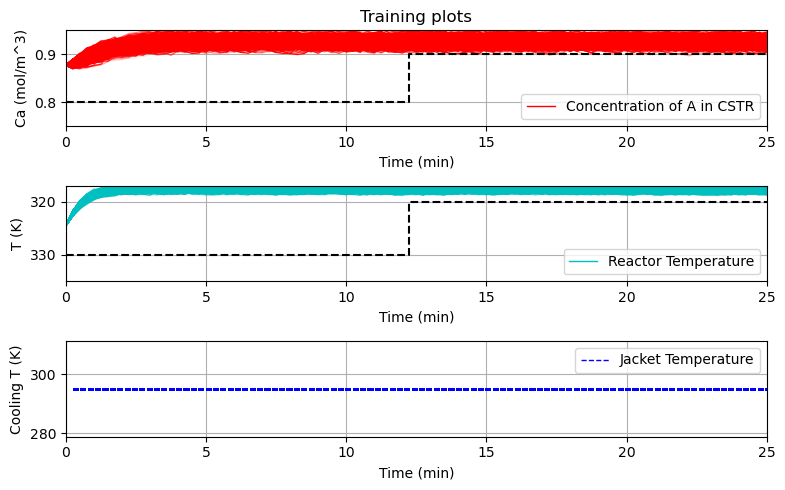

In [112]:
plot_training(data_res, e_tot)

In [10]:
def hpp_search(lower1, upper1, num1, lower2, upper2, num2, algorithm):
    best_rewards = {'coordinates': [], 'values': []}
    times_taken = {'coordinates': [], 'values':[]}
    var1_range = np.linspace(lower1, upper1, num=num1)
    var2_range = np.linspace(lower2, upper2, num=num2)
    var1_coords = []
    var2_coords = []
    
    # var1 = ratio of onlooker to employed
    # var2 = scout limit

    for v1 in var1_range:
        for v2 in var2_range:
            start = time.time()
            best_policy, best_reward = algorithm(lower_bound=-5, upper_bound=5, no_employed=25, no_onlooker=25*v1, no_iterations=50, distance_value=1, scout_limit=v2) 
            end = time.time()
            time_taken = end - start
            best_rewards['coordinates'].append((v1, v2))
            times_taken['coordinates'].append((v1, v2))
            best_rewards['values'].append(best_reward)
            times_taken['values'].append(time_taken)
            var1_coords.append(v1)
            var2_coords.append(v2)

    var1_coords = np.array(var1_coords)
    var2_coords = np.array(var2_coords)
       
    np_times = np.array(times_taken['values'])
    np_rewards = np.array(best_rewards['values'])

    shortest_time = np_times.argmin()
    lowest_reward = np_rewards.argmin()

    shortest_hpp = {'mutation rate': times_taken['coordinates'][shortest_time][0], 'sample size': times_taken['coordinates'][shortest_time][1]}
    best_hpp = {'mutation rate': best_rewards['coordinates'][lowest_reward][0], 'sample_size': best_rewards['coordinates'][lowest_reward][1]}

    time_efficiencies = np_times * np_rewards
    most_efficient = time_efficiencies.argmin()

    efficient_hpp = {'mutation rate': times_taken['coordinates'][most_efficient][0], 'sample size': times_taken['coordinates'][shortest_time][1]}

    max_time = np.max(np_times)
    min_time = np.min(np_times)
    max_reward = np.max(np_rewards)
    min_reward = np.min(np_rewards)

    X = (np_times - min_time) / (max_time - min_time)
    Y = (np_rewards - min_reward) / (max_reward - min_reward)
    # X, Y = np.meshgrid(X,Y)
    Z = (X+1) * (Y+1) - 1
    print(shortest_hpp)
    print(best_hpp)
    print(efficient_hpp)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a scatter plot in 3D with vmin and vmax
    scatter = ax.scatter(var1_coords, var2_coords, Z, cmap=cm.coolwarm, vmin=np.min(Z), vmax=np.max(Z))

    # Set the limits for the Z-axis
    ax.set_zlim(-1, 4)

    # Configure tick locators for the Z-axis
    ax.zaxis.set_major_locator(LinearLocator(10))

    # Add a color bar which maps values to colors
    colorbar = fig.colorbar(scatter, shrink=0.5, aspect=5)

    colorbar.set_label('Time efficiencies')

    # Set labels for the axes
    ax.set_xlabel('Mutation Rates')
    ax.set_ylabel('Sample Sizes')
    ax.set_zlabel('Time efficiencies')

    plt.show()
    
    return shortest_hpp, best_hpp, efficient_hpp



In [23]:
#bestbestreward = best_rewards['values'][lowest_reward]
#print(best_rewards['coordinates'])
#print(best_rewards['values'])
#print(times_taken['values'])
shortest_hpp, best_hpp, efficient_hpp = hpp_search(lower1=0.1, upper1=0.9, num1=9, lower2=0.1, upper2=0.9, num2=9, algorithm=ParticleSwarm)

Iteration 0
Iteration 1
Iteration 2


KeyboardInterrupt: 

Notice that the 'input size' below has an extra +2. This is because we must pass the information to the policy network about the setpoint (given that our setpoint will change). Therefore, we give 2 extra inputs to our policy network, one for each setpoint.

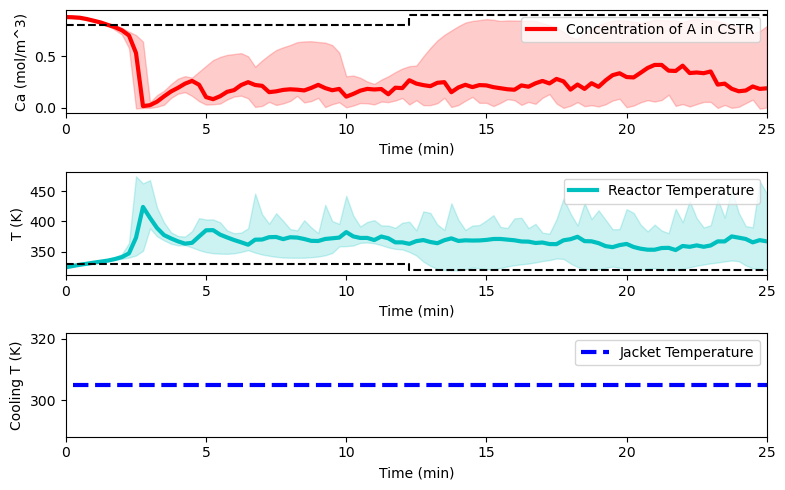

In [110]:
nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy)

reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

### Remarks on stochastic policy search

As it can be observed from the simple example above Stochastic local search methods work well in practice and are much easier to implement that other techniques (such as policy gradients). In general, as we move to large parameter spaces, for example neural networks with millions of parameters, their performance will deteriorate, and a policy gradient-like approach will be more desireable. 

## Policy Gradients 🗻

Policy gradient methods rely on the [Policy Gradient Theorem](https://link.springer.com/article/10.1007/BF00992696) which allows to retrieve the gradient of the expected objective function with respect to policy parameters (neural network weights) $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ through Monte Carlo runs. Given the availability of gradients, it is possible to follow a gradient-based optimization to optimize the policy, generally, Adam or Gradient Descent is used. More information can be found of Chapter 13 on [Reinforcement Learning: An Introduction](http://incompleteideas.net/book/the-book.html). 

In this tutorial notebook we outline the simplest algorithm of this kind, **Reinforce**. For a more in dept introduction to the topic see [Intro to Policy Optimization](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html).

In the case of stochastic policies, the policy function returns the defining parameters of a probability distribution (such as the mean and variance) over possible actions, from which the actions are sampled: 
$$\textbf{u} \sim \pi_\theta(\textbf{u} | \textbf{x}) = \pi(\textbf{u} | \textbf{x}, \theta) = p(\textbf{u} | \textbf{x}, \theta)$$

Note*: this is the same as the stochastic policy introduced earlier, following the 'probability notation'.

To learn the optimal policy, we seek to maximize our performance metric, and hence we can follow a gradient ascent strategy: 
$$\theta_{m+1} = \theta_m + \alpha_m \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] $$

where $m$ is the current iteration that the parameters are updated (epoch), $\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)]$ is the expectation of $f$ over $\pi_\theta$ and $\alpha_m$ is the step size (also termed learning rate in the RL community) for the $m^{th}$ iteration. 

Computing $ \nabla_\theta \hat{f}(\theta) = \nabla_\theta\mathbb{E}_{\pi_\theta}[J(\pi_\theta)]$ directly is difficult, therefore we use the Policy Gradient Theorem, which shows the following:


$$ \begin{alignat}{3}
\nabla_\theta\hat{f}(\theta) = \nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] &~=~\nabla_\theta \int  p(\pi_\theta|\theta)~ f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\int \nabla_\theta p(\pi_\theta|\theta)~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \frac{\nabla_\theta p(\pi_\theta|\theta)}{p(\pi_\theta|\theta)~} ~ f(\pi_\theta) \text{d}\pi_\theta\\
&~=~\int p(\pi_\theta|\theta) ~ \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) f(\pi_\theta)\text{d}\pi_\theta\\
&~=~\mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right]
\end{alignat} $$

Notice from the first expression, that, $p(\pi_\theta|\theta)~ f(\pi_\theta)$ is an objective function value multiplied by its probability density, therefore, integrating this over all possible values of $\pi_\theta$ we obtain the expected value. From there, using simple algebra, logarithms and the chain rule, we arrive at the final equations, which shows an expected value, where, dropping the explicit distribution of $\pi_\theta$, gives us an unbiased gradient estimator, our steepest ascent update now becomes:

$$ \theta_{m+1} = \theta_m + \alpha_m \mathbb{E}_{\pi_\theta}\left[ f(\pi_\theta) \nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) \right] 
$$

Using the expression for $p(\pi_\theta|\theta) = \hat{\mu}(\textbf{x}_0) \prod_{t=0}^{T-1} \left[\pi(\textbf{u}_t|\textbf{x}_t,\theta) p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t) \right]$ and taking its logarithm, we obtain:

$$\nabla_\theta \text{log}\left( p(\pi_\theta|\theta)\right) = \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)$$

Note that since $p(\textbf{x}_{t+1}|\textbf{x}_t,\textbf{u}_t)$ and $\hat{\mu}(\textbf{x}_0)$ are independent of $\theta$ they disappear from the above expression. Then we can rewrite for a trajectory as:

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] = \mathbb{E}_{\pi_\theta} \left[ f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right]$$

The above expression does not require the knowledge of the dynamics of the physical system. Monte-Carlo method is utilized to approximate the expectation.

$$\nabla_\theta \mathbb{E}_{\pi_\theta}[f(\pi_\theta)] \approx \frac{1}{K} \sum_{k=1}^{K} \left( f(\pi_\theta) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t|\textbf{x}_t,\theta)\right)\right)$$


**Reinforce algorithm**

${\bf Input:}$ Initialize policy parameter $\theta = \theta_0$, with $\theta_0\in\Theta_0$, learning rate $\alpha$, set number of episodes $K$ and number of epochs $N$.

${\bf Output:}$ policy $\pi(\cdot | \cdot ,\theta)$ and $\Theta$
\smallskip

${\bf for}$ $m = 1,\dots, N$ ${\bf do}$


1.   Collect $\textbf{u}_t^k , \textbf{x}_t^k,f(\pi_\theta^k)$ for $K$ trajectories of $T$ time steps.
2.   Estimate the gradient $ \hat{g}_m := \frac{1}{K} \sum_{k=1}^{K}  \left[ f(\pi_\theta^k) \nabla_\theta \sum_{t=0}^{T-1} \text{log}\left( \pi(\textbf{u}_t^k|\hat{\textbf{x}}_t^k,\theta)\right)\right]$
3.   Update the policy using a policy gradient estimate $\theta_{m+1} = \theta_m + \alpha_m \hat{g}_m$
4.   $m:=m+1$

${\bf Remark}$: The above algorithm is the base version for many further developments that have been made since it was first proposed. 

The steps of the algorithm are explained below:

${\bf Initialization:}$ The policy network and its weights $\theta$ are initialized along with the algorithm's hyperparameters such as learning rate, number of episodes and number of epochs.

${\bf Training ~~ loop:}$ The weights of the policy network are updated by a policy gradient scheme for a total of $N$ epochs. 

In ${\bf Step 1}$ $K$ trajectories are computed, each trajectory consists of $T$ time steps, and states and control actions are collected. 

In ${\bf Step 2}$ the gradient of the objective function with respect to the weights for the policy network is computed. 

In ${\bf Step 3}$ the weights of the policy network are updated by a gradient ascent scheme. Note that here we show a steepest ascent-like update, but other first order (i.e. Adam) or trust region methods can be used (i.e. PPO, TRPO). 

In ${\bf Step 4}$, either the algorithm terminates or returns to Step 1.

In [58]:
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.distributions import MultivariateNormal

In order to implement and apply the Reinforce algorithm, we are going to perform the following steps in the following subsections:


*   Create a [policy network](#policy_net) that uses transfer learning
*   Create an auxiliary function that selects [control actions](#control_actions) out of the distribution
*   Create an auxilary function that runs [multiple episodes](#multi_episodes) per epoch
*   Finally, put all the pieces together into a function that computes the [Reinforce algorithm](#r_alg)



<a name="policy_net"></a>
### Policy network


In the next section of this tutorial notebook we show an implementation from scratch of a policy optimization algorithm using policy gradients.

Given that we have already optimized the policy via stochastic search in the previous section, we use those parameters as a starting point for policy gradients. This is a form of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning#:~:text=Transfer%20learning%20(TL)%20is%20a,when%20trying%20to%20recognize%20trucks.), which refers to applying knowledge that was previously gained while solving one task to a related task. 

Related to this transfer learning process, we will create a second neural network with the exact same configuration as before, but we will add an extra node to each output of the original neural network to account for the variance term. This is because previously our neural network policy had the structure:

$${\bf u}:=\pi({\bf x};\boldsymbol{\theta})$$

and by a Stochastic search algorithm we manipulated the weights $\boldsymbol{\theta}$ to optimize performance. In policy gradients we output a distribution, rathen than a single value, in this case we output the mean and the variance of a normal distribution (each output now has two values, the mean and the variance), and therefore we must add an extra node to each output such that we have:

$$ \boldsymbol{ \mu }, \boldsymbol{ \Sigma } := \pi({\bf x};\boldsymbol{\theta})$$

$${\bf u} \sim \mathcal{N}(\boldsymbol{ \mu }, \boldsymbol{ \Sigma })$$



In [59]:
#########################################
# Policy Network with transfer learning #
#########################################

class Net_TL(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
  def __init__(self, **kwargs):
    super(Net_TL, self).__init__()

    self.dtype    = torch.float

    # Unpack the dictionary 
    self.args     = kwargs

    # Get info of machine
    self.use_cuda = torch.cuda.is_available() 
    self.device   = torch.device("cpu")

    # Define ANN topology 
    self.input_size = self.args['input_size']
    self.output_sz  = self.args['output_size']
    self.hs1        = self.input_size*2
    self.hs2        = self.output_sz*2 

    # Define layers 
    self.hidden1 = torch.nn.Linear(self.input_size, self.hs1 )
    self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
    self.output  = torch.nn.Linear(self.hs2, self.output_sz)

  def forward(self, x):
    #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
    x = x.view(1, 1, -1).float()
    y = Ffunctional.leaky_relu(self.hidden1(x), 0.1)
    y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
    y = Ffunctional.relu6(self.output(y))   # range (0,6)

    return y

  def increaseClassifier(self, m:torch.nn.Linear):
    w         = m.weight
    b         = m.bias
    old_shape = m.weight.shape

    m2        = nn.Linear( old_shape[1], old_shape[0] + 1)
    m2.weight = nn.parameter.Parameter( torch.cat( (m.weight, m2.weight[0:1]) ), 
                                       requires_grad=True )
    m2.bias   = nn.parameter.Parameter( torch.cat( (m.bias, m2.bias[0:1]) ), 
                                       requires_grad=True)
    return m2
  
  def incrHere(self): 
    self.output = self.increaseClassifier(self.output)

Notice that just as before, we ad a +2 to the input, as thisrefers to the current set-point value.

In [60]:
nx            = 2
nu            = 1
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2

policy_net_pg = Net_TL(**hyparams, requires_grad=True, retain_graph=True)
policy_net_pg.load_state_dict(best_policy) # Transfer learning
policy_net_pg.incrHere()

<a name="control_actions"></a>
### Control action selection


In [61]:
################################
# action selection from Normal #
################################

def select_action(control_mean, control_sigma):
    """
    Sample control actions from the distribution their distribution
    input: Mean, Variance
    Output: Controls, log_probability, entropy
    """
    s_cov          = control_sigma.diag()**2
    dist           = MultivariateNormal(control_mean, s_cov)
    control_choice = dist.sample()                 # sample control from N(mu,std)
    log_prob       = dist.log_prob(control_choice) # compute log prob of this action (how likely or unlikely)
    entropy        = dist.entropy()                # compute the entropy of the distribution N(mu, std)
    
    return control_choice, log_prob, entropy

#########################
# un-normalizing action #
#########################

def mean_std(m, s, mean_range=[10], mean_lb=[295], std_range=[0.001]):
    '''
    Problem specific restrictions on predicted mean and standard deviation.
    '''
    mean = Tensor(mean_range) * m/6 + Tensor(mean_lb) # ReLU6
    std  = Tensor(std_range)  * s/6
    
    return mean, std

<a name="multi_episodes"></a>
### Multiple episodes - one epoc/training step


In [62]:
################
# one epoc run #
################

def epoc_run(NNpolicy, episodes_n):
    '''This function runs episodes_n episodes and collected the data. This data
    is then used for one gradient descent step.

    INPUTS
    NNpolicy:   the NN policy
    episodes_n: number of episodes per epoc (gradient descent steps)
    data_train: dictionary of data collected

    OUTPUTS
    data_train: collected data to be passed to the main training loop
    '''

    # run episodes
    logprobs_list = [] # log probabilities is the policies itself p(a|s)
    reward_list   = [] # reward
    for epi_i in range(episodes_n):
        reward_, sum_logprob = J_PolicyCSTR(NNpolicy, policy_alg='PG_RL', 
                                            collect_training_data=True, episode=True)
        logprobs_list.append(sum_logprob)
        reward_list.append(reward_)

    # compute mean and expectation of rewards
    reward_m   = np.mean(reward_list)
    reward_std = np.std(reward_list)
    

    # compute the baseline (reverse sum)
    log_prob_R = 0.0
    for epi_i in reversed(range(episodes_n)):
        baselined_reward = (reward_list[epi_i] - reward_m) / (reward_std + eps)
        log_prob_R       = log_prob_R - logprobs_list[epi_i] * baselined_reward

    # mean log probability
    mean_logprob = log_prob_R/episodes_n
    reward_std   = reward_std
    reward_m     = reward_m

    return mean_logprob, reward_std, reward_m 

<a name="r_alg"></a>
### Reinforce algorithm

Now, let's create a function that put all pieces together and implements the Reinforce algorithm explained above

In [63]:
def Reinforce(policy, optimizer, n_epochs, n_episodes):

    # lists for plots
    rewards_m_record = []; rewards_std_record = []

    for epoch_i in range(n_epochs):

        # collect data
        mean_logprob, reward_std, reward_m = epoc_run(policy, n_episodes)

        # Expected log reward 
        E_log_R = mean_logprob
        optimizer.zero_grad()
        E_log_R.backward()
        optimizer.step()

        # save data for analysis
        rewards_m_record.append(reward_m)
        rewards_std_record.append(reward_std)

        # schedule to reduce lr
        scheduler.step(E_log_R)

        if epoch_i%int(n_epochs/10)==0:
            mean_r = reward_m
            std_r  = reward_std
            print('epoch:', epoch_i)
            print(f'mean reward: {mean_r:.3} +- {std_r:.2}')

    return rewards_m_record, rewards_std_record, policy

### Apply the Reinforce algorithm

Now that we have the algorithm, let's apply it to the problem. 

Let's choose some problem parameters and initialize storing lists

In [64]:
# problem parameters
lr         = 0.0001
total_it   = 2000
n_episodes = 50
n_epochs   = int(total_it/n_episodes)

# data for plots
data_res['Ca_train']    = []; data_res['T_train']     = [] 
data_res['Tc_train']    = []; data_res['err_train']   = []
data_res['u_mag_train'] = []; data_res['u_cha_train'] = []

define the policy and the optimizer to be used

In [65]:
# define policy and optimizer
control_policy = policy_net_pg
optimizer_pol  = optim.Adam(control_policy.parameters(), lr=lr)

define the learning rate scheduler

In [66]:
# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_pol, factor=0.5, patience=10, verbose=True, min_lr=0.000001,
    cooldown = 10)

and apply the algorithm

```{note} Runing the algorithm will last for a few minutes
```

In [67]:
rewards_m_record, rewards_std_record, optimal_Reinforce = \
Reinforce(control_policy, optimizer_pol, n_epochs, n_episodes)

/var/folders/qq/j7gysh0d1x54nchfxgzn4lb40000gn/T/ipykernel_18911/3967602739.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tc[i]                     = u_k


epoch: 0
mean reward: -23.7 +- 0.82
epoch: 4
mean reward: -23.5 +- 0.69
epoch: 8
mean reward: -23.7 +- 0.77
epoch: 12
mean reward: -23.9 +- 0.82
epoch: 16
mean reward: -23.9 +- 0.92
Epoch 00019: reducing learning rate of group 0 to 5.0000e-05.
epoch: 20
mean reward: -23.6 +- 1.1
epoch: 24
mean reward: -23.5 +- 0.95
epoch: 28
mean reward: -23.6 +- 0.98
epoch: 32
mean reward: -23.4 +- 0.89
epoch: 36
mean reward: -23.4 +- 0.86
Epoch 00040: reducing learning rate of group 0 to 2.5000e-05.


Let's visualize now

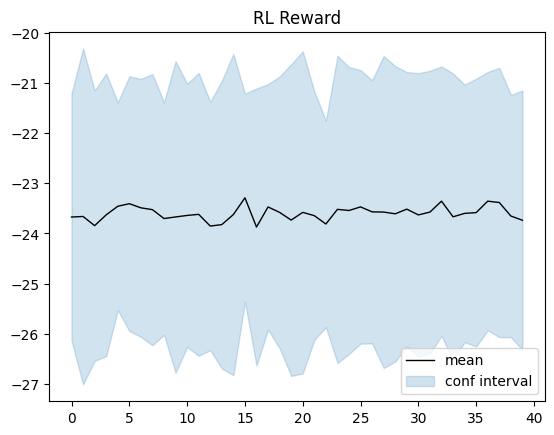

In [68]:
# plot the samples of posteriors
plt.plot(rewards_m_record, 'black', linewidth=1)
# plot GP confidence intervals
iterations = [i for i in range(len(rewards_m_record))]
plt.gca().fill_between(iterations, np.array(rewards_m_record) - 3*np.array(rewards_std_record), 
                       np.array(rewards_m_record) + 3*np.array(rewards_std_record), 
                       color='C0', alpha=0.2)
plt.title('RL Reward')
plt.legend(('mean', 'conf interval'),
           loc='lower right')
plt.show()

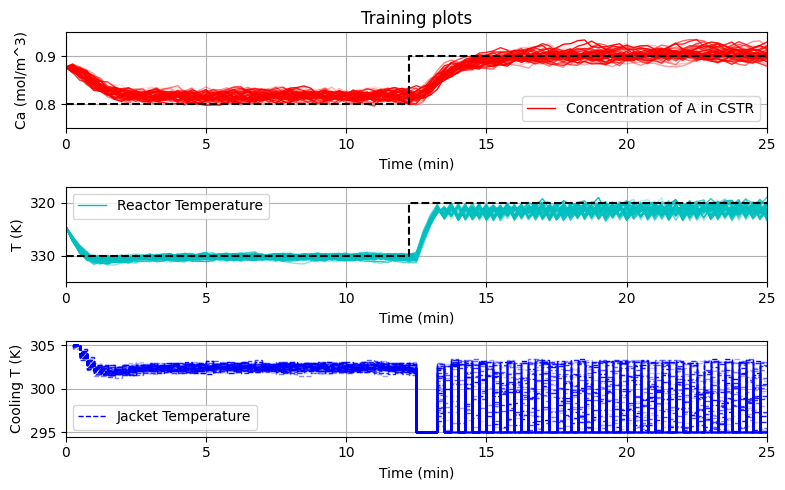

In [69]:
plot_training(data_res, e_tot)

/var/folders/qq/j7gysh0d1x54nchfxgzn4lb40000gn/T/ipykernel_18911/3967602739.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tc[i]                     = u_k


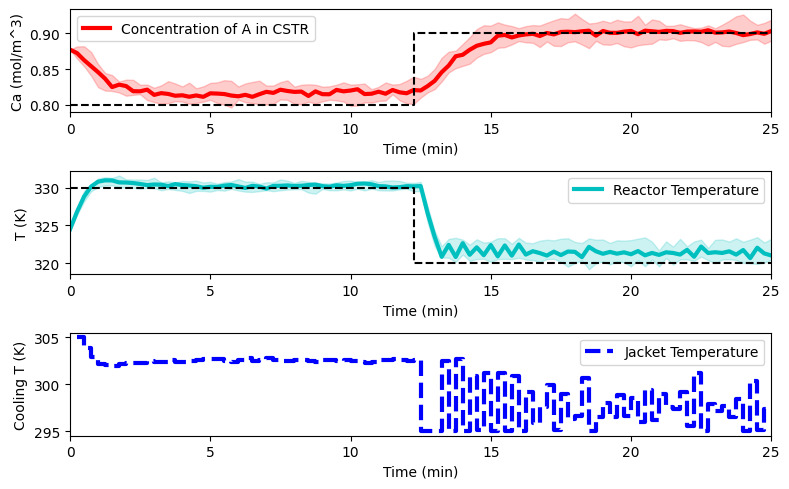

In [70]:
reps = 10

Ca_eval = np.zeros((data_res['Ca_dat'].shape[0], reps))
T_eval = np.zeros((data_res['T_dat'].shape[0], reps))
Tc_eval = np.zeros((data_res['Tc_dat'].shape[0], reps))

for r_i in range(reps):
  Ca_eval[:,r_i], T_eval[:,r_i], Tc_eval[:,r_i] = J_PolicyCSTR(policy_net_pg,
                                                               policy_alg='PG_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)
# Plot the results
plot_simulation(Ca_eval, T_eval, Tc_eval, data_res)

## Extra material on RL for ChemEng 🤓

If you would like to read more about the use of reinforcement learning in chemical engineering systems:

**Applications** 

*   Reinforcement learning offers potential for bringing significant improvements to [industrial batch process control practice](https://www.sciencedirect.com/science/article/abs/pii/S136757882100081X) even in [discontinous and nonlinear systems](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168).
*   RL has also been used to address [chemical production scheduling](https://www.sciencedirect.com/science/article/pii/S0098135420301599) and [multi-echelon supply chains](https://www.sciencedirect.com/science/article/pii/S2772508122000643)
*   Other applications include [PID tuning](https://www.sciencedirect.com/science/article/abs/pii/S0967066121002963), [real-time optimization](https://www.mdpi.com/2227-9717/11/1/123), [searching for optimal process routes](https://www.sciencedirect.com/science/article/abs/pii/S0098135420303999), [flowsheet generation](https://aiche.onlinelibrary.wiley.com/doi/full/10.1002/aic.17938), [bioreactors](https://www.sciencedirect.com/science/article/abs/pii/S0098135419304168) and [biotherapeutics](https://onlinelibrary.wiley.com/doi/10.1002/bit.28346), amongst many others.

**Methodologies** 

*   Constraints to address [plant-model mismatch](https://www.sciencedirect.com/science/article/abs/pii/S0098135421004087), [constrained Q-learning](https://www.sciencedirect.com/science/article/abs/pii/S0098135421002404), [safe reinforcement learning](https://www.researchgate.net/publication/368302457_Safe_deployment_of_reinforcement_learning_using_deterministic_optimization_of_trained_neural_networks), satisfaction of constraints with [high probability](https://www.sciencedirect.com/science/article/pii/S0959152422000038), and [dynamic penalties](https://www.sciencedirect.com/science/article/pii/S0959152422000816) for better convergence.
*   [Process control](https://www.mdpi.com/2227-9717/10/11/2311), [meta-reinforcement learning](https://www.sciencedirect.com/science/article/pii/S0959152422001445), [general economic process control](https://www.sciencedirect.com/science/article/pii/S0098135420307912), amongst many many others. 

 